In this notebook we set out an exercise to do backtesting to compare different models for multiple time series. The solutions we show are only one way of answering these questions.

Note: Since recording the videos, skforecast have made breaking changes to their API in newer versions (>= 0.14). This notebook has been updated for use with skforecast version 0.14 and above, which are the versions with a new API. If you are using older versions of skforecast (<0.14) see the migration guide here: https://skforecast.org/0.14.0/user_guides/migration-guide.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data preparation

The dataset we shall use is the Quarterly overnight trips (in thousands) from 1998 Q1 to 2016 Q4 across
Australia. The number of trips is split by `State`, `Region`, and `Purpose`. 

**In this exercise we are going to forecast the total number of trips for each Region (there are 76 regions therefore we will have 76 time series). We shall treat this as a multiple independent time series forecasting problem.**

Source: A new tidy data structure to support
exploration and modeling of temporal data, Journal of Computational and
Graphical Statistics, 29:3, 466-478, doi:10.1080/10618600.2019.1695624.
Shape of the dataset: (24320, 5)

In [2]:
from skforecast.datasets import fetch_dataset

# Load the data
data = fetch_dataset(name="australia_tourism", raw=True)
data.head()

australia_tourism
-----------------
Quarterly overnight trips (in thousands) from 1998 Q1 to 2016 Q4 across
Australia. The tourism regions are formed through the aggregation of Statistical
Local Areas (SLAs) which are defined by the various State and Territory tourism
authorities according to their research and marketing needs.
Wang, E, D Cook, and RJ Hyndman (2020). A new tidy data structure to support
exploration and modeling of temporal data, Journal of Computational and
Graphical Statistics, 29:3, 466-478, doi:10.1080/10618600.2019.1695624.
Shape of the dataset: (24320, 5)


,date_time,Region,State,Purpose,Trips
0,1998-01-01,Adelaide,South Australia,Business,135.077690
1,1998-04-01,Adelaide,South Australia,Business,109.987316
2,1998-07-01,Adelaide,South Australia,Business,166.034687
3,1998-10-01,Adelaide,South Australia,Business,127.160464
4,1999-01-01,Adelaide,South Australia,Business,137.448533


Pre-process the data by performing the following:
1) Convert the `date_time` column to datetime type
2) Create a dataframe with one column per `Region` which gives the total number of Trips for each date.
3) Ensure the index is `date_time` and resampled to quarterly start `QS`


In [3]:
data["date_time"] = pd.to_datetime(data["date_time"])
data = data.groupby(["date_time", "Region"])["Trips"].sum().unstack()
data = data.asfreq("QS")
data.head()

Region,Adelaide,Adelaide Hills,Alice Springs,Australia's Coral Coast,Australia's Golden Outback,Australia's North West,Australia's South West,Ballarat,Barkly,Barossa,...,Sunshine Coast,Sydney,The Murray,Tropical North Queensland,Upper Yarra,Western Grampians,Whitsundays,Wilderness West,Wimmera,Yorke Peninsula
date_time,,,,,,,,,,,,,,,,,,,,,
1998-01-01,658.553895,9.798630,20.207638,132.516409,161.726948,120.775450,474.858729,182.239341,18.465206,46.796083,...,742.602299,2288.955629,356.500087,220.915346,102.791022,86.996591,60.226649,63.335097,18.804743,160.681637
1998-04-01,449.853935,26.066952,56.356223,172.615378,164.973780,158.404387,411.622281,137.566539,7.510969,49.428717,...,609.883333,1814.459480,312.291189,253.097616,74.855136,84.939977,106.190848,42.607076,52.482311,104.324252
1998-07-01,592.904597,26.491072,110.918441,173.904335,206.879934,184.619035,360.039657,117.642761,43.565625,29.743302,...,615.306331,1989.731939,376.718698,423.506735,59.465405,79.974884,81.771005,18.851214,35.657551,68.996468
1998-10-01,524.242760,27.256859,40.868270,207.002571,198.509591,138.878263,462.620050,136.072724,29.359239,78.193066,...,684.430239,2150.913627,336.367694,283.694451,35.238855,116.235617,105.600143,50.450965,27.204455,103.340264
1999-01-01,548.394105,13.772975,48.368038,198.856638,140.213443,103.337122,562.974629,156.456242,6.341997,35.277910,...,842.167418,1779.286905,323.418472,194.509904,67.823457,101.765635,111.504972,59.888003,50.219851,146.658290


Later we will use LightGBM. It does not support special JSON characters (e.g., `'`)  in the column name. Let's remove these characters from the column names.

In [4]:
import re

data = data.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))

Check for missing values.

In [5]:
data.isnull().any().any()

False

# Exploratory data analysis

Print the number of data points in the time series, the start time, and the end time of the time series.

In [6]:
print(len(data))
print(f"start: {data.index.min()}, end: {data.index.max()}")

80
start: 1998-01-01 00:00:00, end: 2017-10-01 00:00:00


Plot the time series summed over all regions.

Text(0.5, 1.0, 'Quartely trips (thousands) - Total')

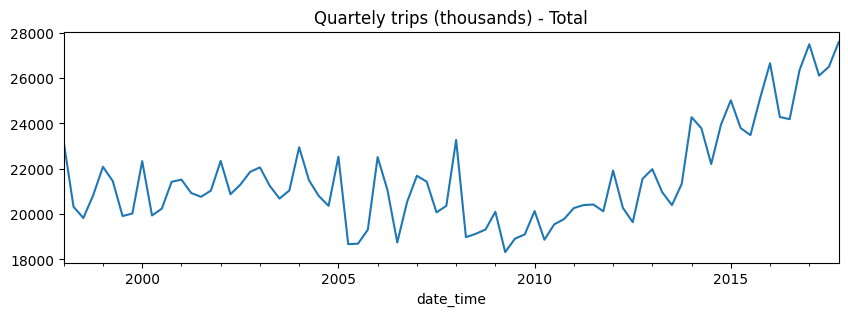

In [7]:
fig, ax = plt.subplots(figsize=[10, 3])
data.sum(axis=1).plot(ax=ax)
ax.set_title("Quartely trips (thousands) - Total")

Plot a subsample of the time series from different regions.

Text(0.5, 1.0, 'Quartely trips (thousands)')

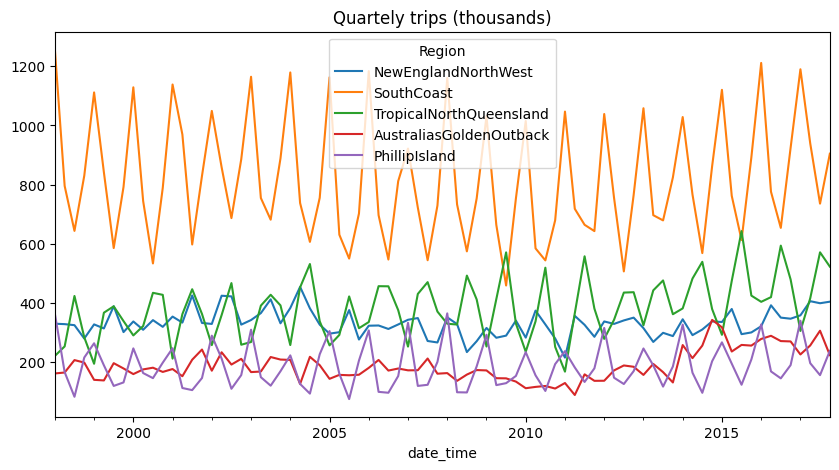

In [8]:
fig, ax = plt.subplots(figsize=[10, 5])
data.sample(n=5, axis=1, random_state=123).plot(ax=ax)
ax.set_title("Quartely trips (thousands)")

It appears that there is yearly seasonality for these series and they appear to be anti-correlated (i.e., some areas experience peaks whilst others experience troughs).

Create a quarter of the year feature which could help with this.

In [9]:
data["quarter"] = data.index.quarter

# Model definition

Import the classes needed for recursive forecasting for multiple time series and window features from `skforecast`.

In [10]:
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.preprocessing import RollingFeatures

Import a transformer from sklearn to scale the data.

In [11]:
# Preprocessing and features
from sklearn.preprocessing import StandardScaler

Import a linear model and LightGBM

In [12]:
# Traditional machine learning models
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor

Define an object that extracts features from the target variable:
- A rolling mean with window 4
- A rolling standard deviation with window 4
- A rolling mean with window 12
- A rolling standard deviation with window 12


In [13]:
window_features = RollingFeatures(
    stats = ["mean", "std"], # The statistics to calculate
    window_sizes = [4, 12], # The window sizes to calculate the statistics
)

window_features

RollingFeatures(
    stats           = ['mean', 'std'],
    window_sizes    = [4, 12],
    Max window size = 12,
    min_periods     = [4, 12],
    features_names  = ['roll_mean_4', 'roll_std_12'],
    fillna          = None
)

Define one forecaster for the linear model and one forecaster for the LightGBM model  using `skforecast`. Pass the function in the previous cell as an argument. Use all lags of up to 8.


In [14]:
# Create linear forecaster
linear_forecaster = ForecasterRecursiveMultiSeries(
    regressor=Ridge(alpha=1),
    lags=8,
    window_features=window_features,
    transformer_series=StandardScaler(),  # Scaling helpful for
    transformer_exog=StandardScaler(),  # linear models.
)

# Create LightGBM forecaster
params_lgbm = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 10,
    "random_state": 123,
    "verbose": -1,
}

lightgbm_forecaster = ForecasterRecursiveMultiSeries(
    regressor=LGBMRegressor(**params_lgbm),
    lags=8,
    window_features=window_features,
)

# Backtesting

Import the relevant backtesting objects from `skforecast`.

In [15]:
from skforecast.model_selection import backtesting_forecaster_multiseries, TimeSeriesFold

Assign the name of the target variables and exogenous variables to variables called `target_cols` and `exog_cols`.

In [16]:
exog_cols = ["quarter"]
target_cols = data.drop(columns=exog_cols).columns

Use the backtesting function to do backtesting with:
- Refitting at every step
- An expanding training window
- Use the `mean_absolute_error` as the error metric
- Use the first 13 datapoints (just over 3 years) as initial training size
- Use exogenous features
- Set the forecast horizon to be 4 steps (i.e., 1 year)

Do this twice, once for the linear forecaster and once for the lightgbm forecaster.

In [17]:
# Define how time series will be split during backtesting
cv = TimeSeriesFold(
    steps=4,
    initial_train_size=13,
    refit=True,
    allow_incomplete_fold=True,
    fixed_train_size=False,
)

In [18]:
# Linear forecaster backtesting
metric_linear, predictions_linear = backtesting_forecaster_multiseries(
    forecaster=linear_forecaster,
    series=data[target_cols],
    exog=data[exog_cols],
    cv=cv,
    metric="mean_absolute_error",
    verbose=True,
    show_progress=True,
)

Information of folds
--------------------
Number of observations used for initial training: 13
Number of observations used for backtesting: 67
    Number of folds: 17
    Number skipped folds: 0 
    Number of steps per fold: 4
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   1998-01-01 00:00:00 -- 2001-01-01 00:00:00  (n=13)
    Validation: 2001-04-01 00:00:00 -- 2002-01-01 00:00:00  (n=4)
Fold: 1
    Training:   1998-01-01 00:00:00 -- 2002-01-01 00:00:00  (n=17)
    Validation: 2002-04-01 00:00:00 -- 2003-01-01 00:00:00  (n=4)
Fold: 2
    Training:   1998-01-01 00:00:00 -- 2003-01-01 00:00:00  (n=21)
    Validation: 2003-04-01 00:00:00 -- 2004-01-01 00:00:00  (n=4)
Fold: 3
    Training:   1998-01-01 00:00:00 -- 2004-01-01 00:00:00  (n=25)
    Validation: 2004-04-01 00:00:00 -- 2005-01-01 00:00:00  (n=4)
Fold: 4
    Training:   1998-01-01 00:00:00 -- 2005-01-01 00:00:00

  0%|          | 0/17 [00:00<?, ?it/s]

In [19]:
# LightGBM backtesting
metric_lightgbm, predictions_lightgbm = backtesting_forecaster_multiseries(
    forecaster=lightgbm_forecaster,
    series=data[target_cols],
    exog=data[exog_cols],
    cv=cv,
    metric="mean_absolute_error",
    verbose=True,
    show_progress=True,
)

Information of folds
--------------------
Number of observations used for initial training: 13
Number of observations used for backtesting: 67
    Number of folds: 17
    Number skipped folds: 0 
    Number of steps per fold: 4
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   1998-01-01 00:00:00 -- 2001-01-01 00:00:00  (n=13)
    Validation: 2001-04-01 00:00:00 -- 2002-01-01 00:00:00  (n=4)
Fold: 1
    Training:   1998-01-01 00:00:00 -- 2002-01-01 00:00:00  (n=17)
    Validation: 2002-04-01 00:00:00 -- 2003-01-01 00:00:00  (n=4)
Fold: 2
    Training:   1998-01-01 00:00:00 -- 2003-01-01 00:00:00  (n=21)
    Validation: 2003-04-01 00:00:00 -- 2004-01-01 00:00:00  (n=4)
Fold: 3
    Training:   1998-01-01 00:00:00 -- 2004-01-01 00:00:00  (n=25)
    Validation: 2004-04-01 00:00:00 -- 2005-01-01 00:00:00  (n=4)
Fold: 4
    Training:   1998-01-01 00:00:00 -- 2005-01-01 00:00:00

  0%|          | 0/17 [00:00<?, ?it/s]

Merge the two metrics dataframe into a single dataframe to make it easier to compare the errors between the linear model and the LightGBM model. 

In [20]:
metrics = metric_lightgbm.merge(
    right=metric_linear, on="levels", suffixes=["_lightgbm", "_linear"]
)

How often did one model outperform the other model? Remember, the lower the error the better.

In [21]:
# Fraction of rows where the linear model outperformed the lightgbm
sum(
    metrics["mean_absolute_error_linear"] < metrics["mean_absolute_error_lightgbm"]
) / len(metrics)

0.759493670886076

It looks like Ridge was better for most time series here. Once again, for the lightgbm model to outperform we might need additional feature engineering, hyperparameter tuning, handling of trends, and more data. There are not any features which help group similar time series together - these type of features are normally well utilised by gradient boosted trees. So in this scenario, a simple linear model works better.

Compute the mean absolute error over all the predictions for both the linear model and the LightGBM model. Compare them.

In [22]:
from sklearn.metrics import mean_absolute_error

mae_linear = mean_absolute_error(
    y_true=data[target_cols].loc[predictions_linear.index],
    y_pred=predictions_linear,
)

mae_lightgbm = mean_absolute_error(
    y_true=data[target_cols].loc[predictions_lightgbm.index],
    y_pred=predictions_lightgbm,
)


print(f"{mae_linear=}, {mae_lightgbm=}")

mae_linear=35.66169785946647, mae_lightgbm=41.00398715315218


Plot the predictions made during backtesting alongside the actuals for a **random subset** of time series to get a better understanding of the errors.

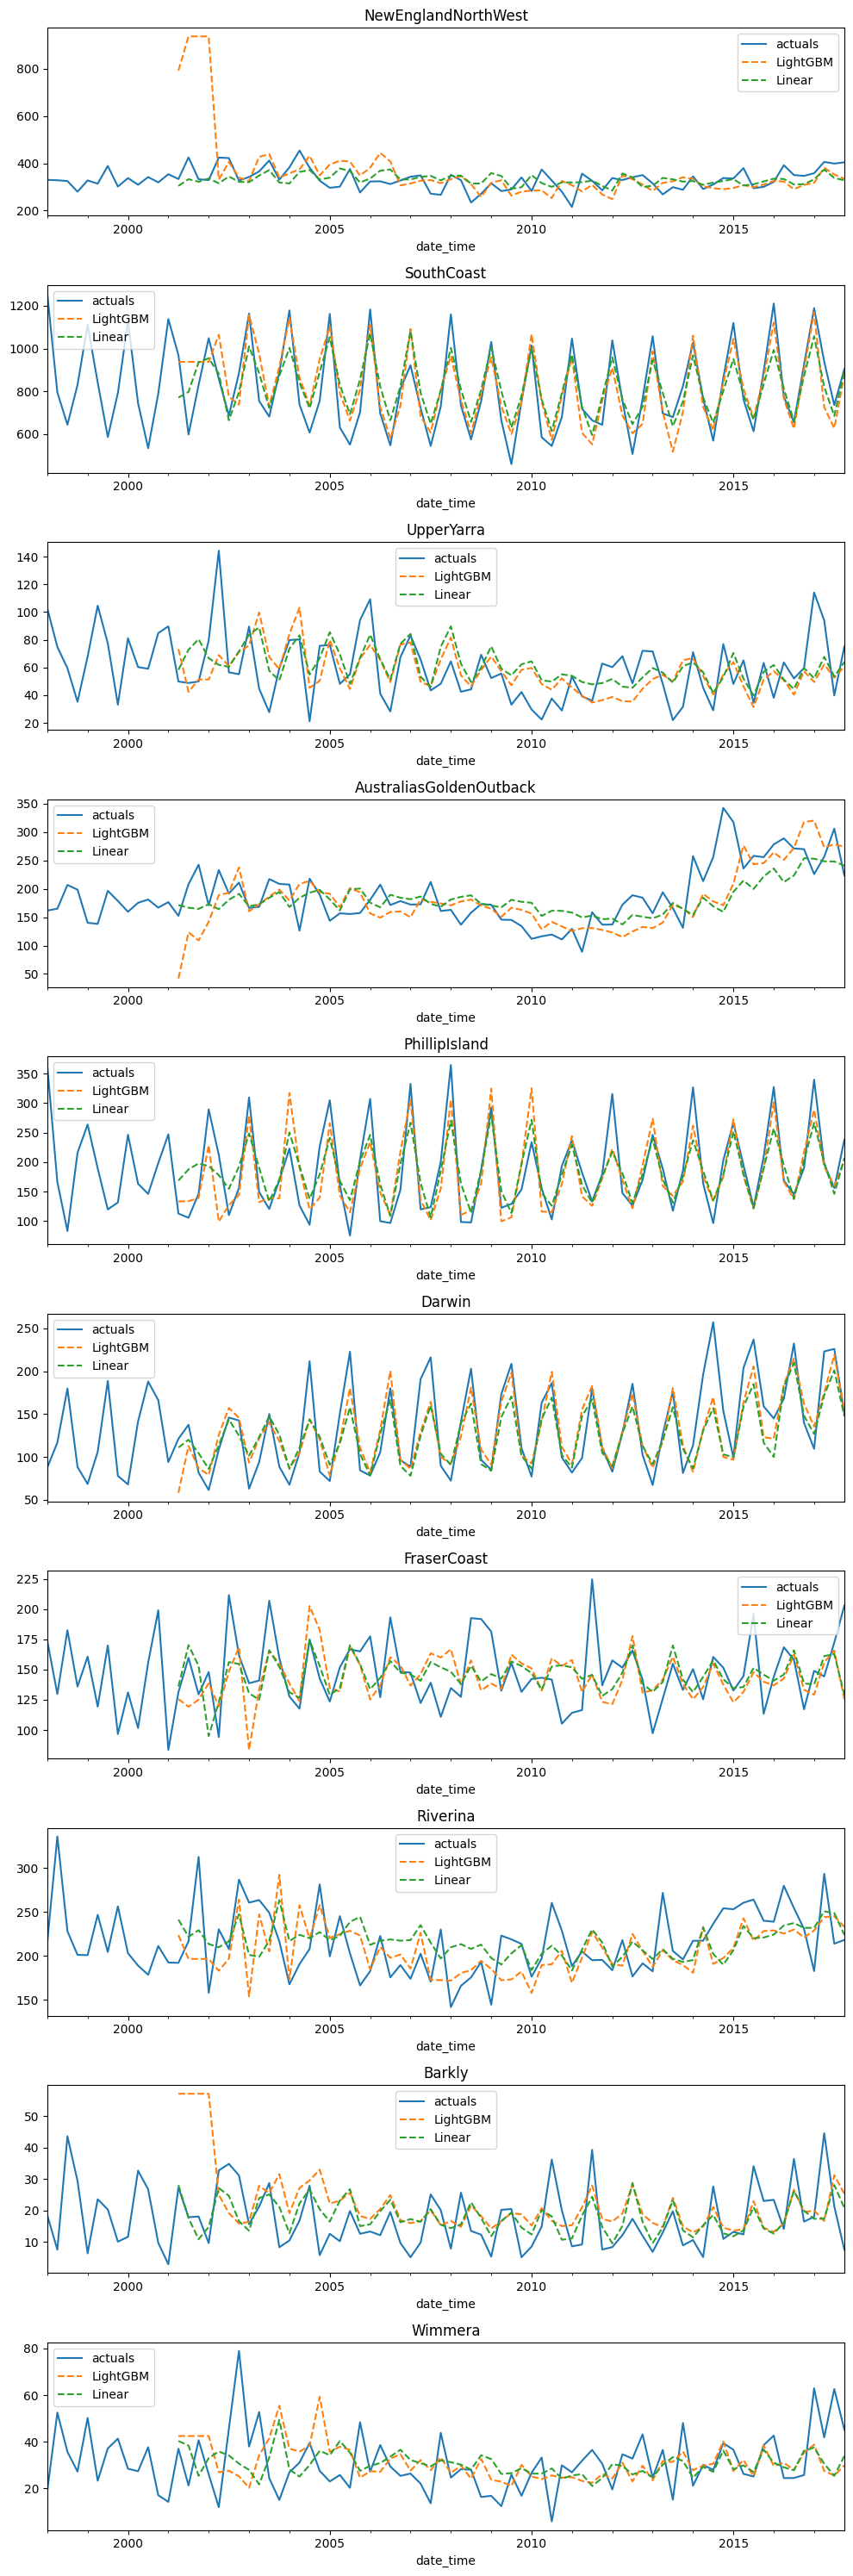

In [23]:
# Select a random subsample of timeseries
num_timeseries = 10
data_subset = data.sample(n=num_timeseries, axis=1, random_state=123)

# Plotting
fig, axs = plt.subplots(nrows=num_timeseries, figsize=[10, 3 * num_timeseries])
for ix in range(num_timeseries):
    region = data_subset.columns[ix]
    ax = axs[ix]
    data_subset.loc[:, region].plot(ax=ax, label="actuals")
    predictions_lightgbm.loc[:, region].plot(ax=ax, linestyle="--", label="LightGBM")
    predictions_linear.loc[:, region].plot(ax=ax, linestyle="--", label="Linear")
    ax.legend()
    ax.set_title(f"{region}")
plt.tight_layout()

Plot the predictions made during backtesting alongside the actuals for the **highest error** subset of time series to get a better understanding of the errors.

In [24]:
metrics["mean_error"] = metrics[
    ["mean_absolute_error_lightgbm", "mean_absolute_error_linear"]
].mean(axis=1)

In [25]:
metrics.nlargest(n=10, columns=["mean_error"])

,levels,mean_absolute_error_lightgbm,mean_absolute_error_linear,mean_error
67,Sydney,217.502947,145.538590,181.520768
49,Melbourne,155.754829,151.243233,153.499031
12,Brisbane,147.764606,115.846868,131.805737
54,NorthCoastNSW,118.142989,79.913926,99.028457
25,ExperiencePerth,102.529073,90.826653,96.677863
64,SouthCoast,86.792953,90.914143,88.853548
66,SunshineCoast,87.759108,73.759690,80.759399
6,AustraliasSouthWest,71.820002,73.810833,72.815418
69,TropicalNorthQueensland,82.574242,61.457915,72.016079
32,GoldCoast,75.653821,56.868035,66.260928


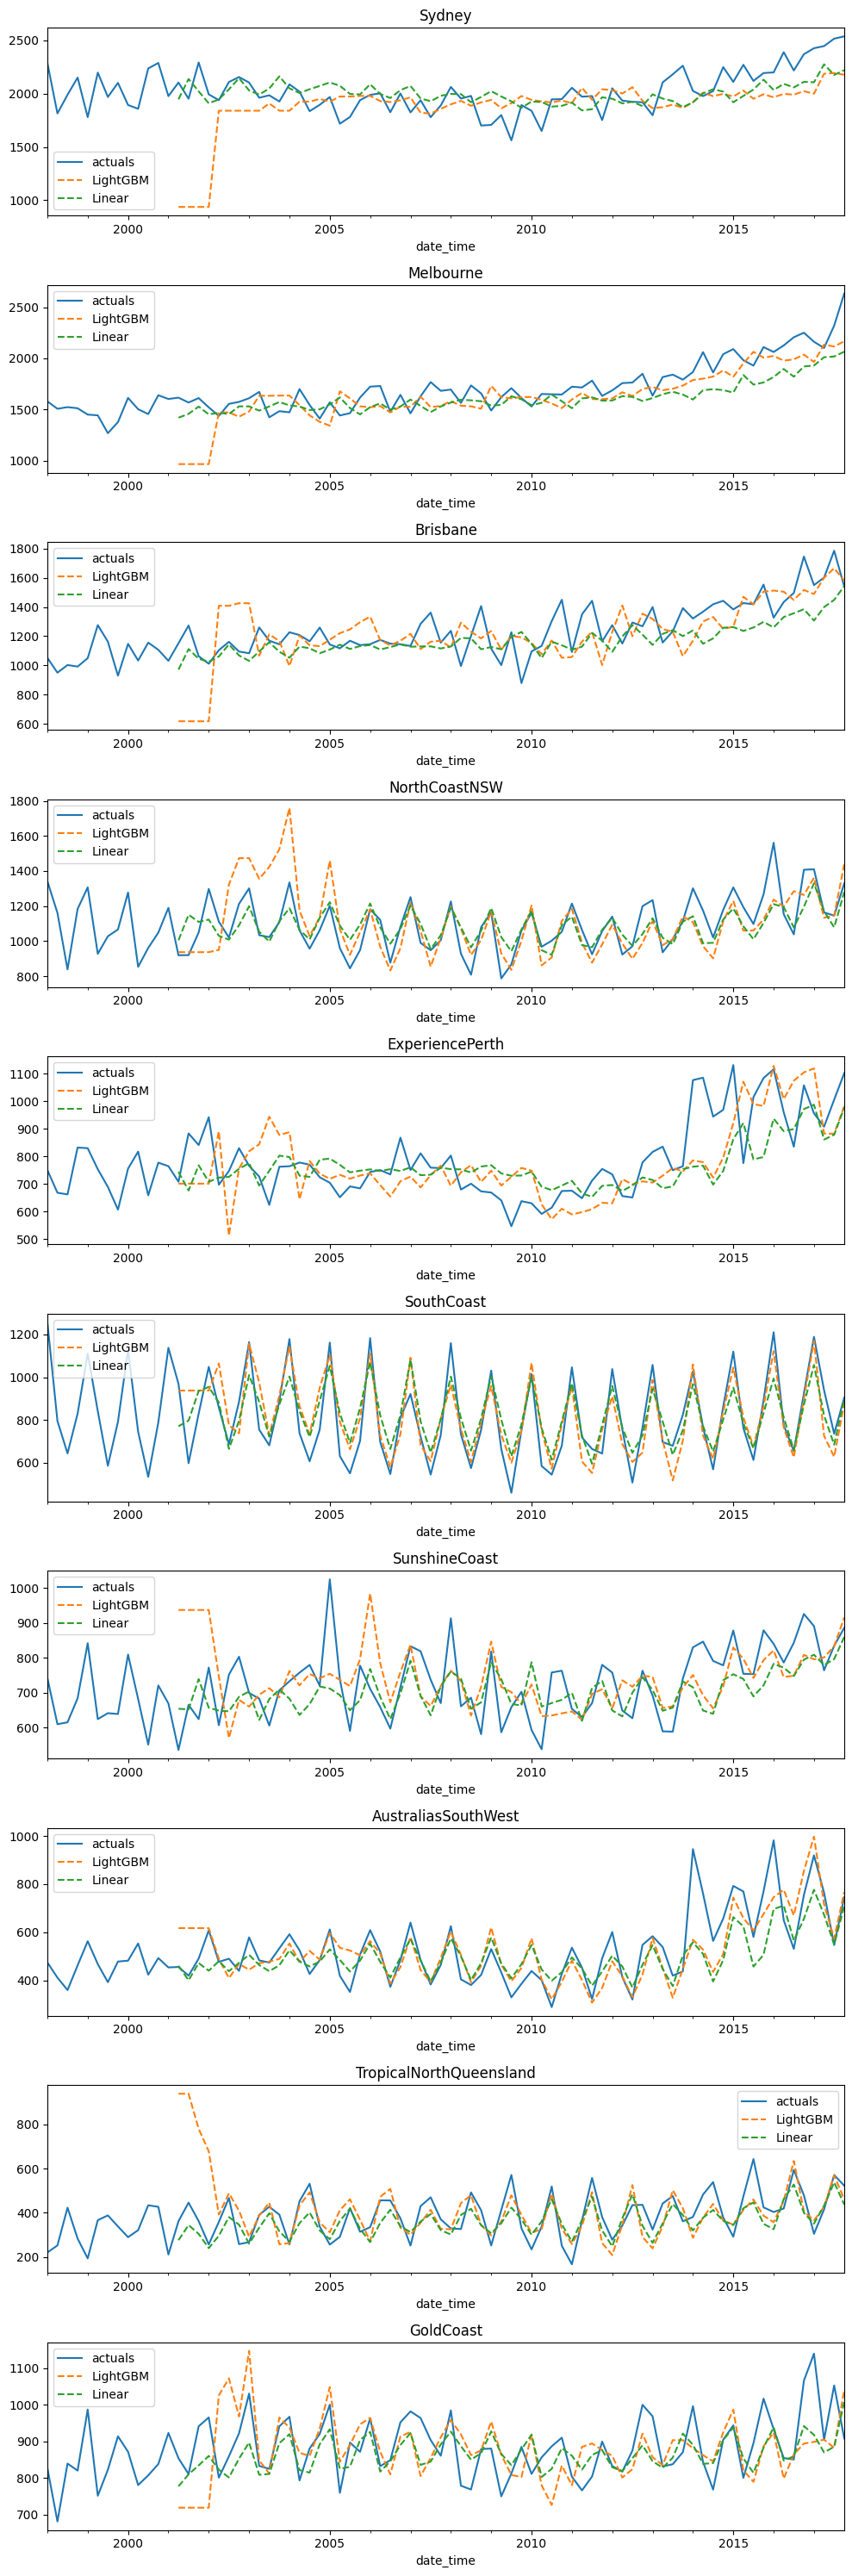

In [26]:
num_timeseries = 10

# Select the timeseries with the highest error across both models
metrics["mean_error"] = metrics[
    ["mean_absolute_error_lightgbm", "mean_absolute_error_linear"]
].mean(axis=1)

regions = metrics.nlargest(n=10, columns=["mean_error"])["levels"].values

# Plotting
fig, axs = plt.subplots(nrows=num_timeseries, figsize=[10, 3 * num_timeseries])
for ix in range(num_timeseries):
    region = regions[ix]
    ax = axs[ix]

    data.loc[:, region].plot(ax=ax, label="actuals")
    predictions_lightgbm.loc[:, region].plot(ax=ax, linestyle="--", label="LightGBM")
    predictions_linear.loc[:, region].plot(ax=ax, linestyle="--", label="Linear")
    ax.legend()
    ax.set_title(f"{region}")
plt.tight_layout()